### 2018/2019 - Task List 4

[Book](https://raw.githubusercontent.com/jonesgithub/book-1/master/ML%20Machine%20Learning-A%20Probabilistic%20Perspective.pdf)

[A priori](https://en.wikipedia.org/wiki/A_priori_probability)

[Likelihood](https://en.wikipedia.org/wiki/Likelihood_function)

[Posteriori](https://en.wikipedia.org/wiki/Posterior_distribution)

[Conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior)

Pyro
[Conditioning](http://pyro.ai/examples/intro_part_ii.html#Conditioning)

Pyro [SVI](http://pyro.ai/examples/svi_part_i.html#Setup)

1.  Select one attriubte from one of the datasets (Task List 3), that has distribution similar to Normal (or any known to you distribution)
2.  Asume that you have some prior knowledge about parameters of that distribution
3.  Create model, and apropriate guid function
4. Learn parameter of your distribution, assume that you know STD or mean

## Required imports

In [5]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from pyro.optim import Adam
from torch.distributions import constraints
from tqdm import tqdm
from matplotlib import animation, rc
from IPython.display import HTML

import pandas as pd

#  Example of SVI

Generate some sample data of weight measurments

In [416]:
mean, var = 100, 10
with pyro.plate("generator", 1000) as _:
    data = pyro.sample('data', pyro.distributions.Normal(mean, var))
    
prior_mean=80


In [417]:
data

tensor([105.0914, 116.1406, 104.3839, 106.8700, 104.5003, 125.1590,  95.2050,
         88.6723,  94.0512, 106.8381, 100.6561, 103.1847,  99.4775, 101.4996,
        107.5299,  98.9761,  83.6353,  94.2215, 107.0887,  95.5333,  96.4519,
         95.6250, 107.0740, 108.0457,  94.1864,  79.0377,  93.1574, 106.2431,
        103.3428, 119.6000,  91.2574,  94.0433,  80.5369, 107.9583,  94.9623,
         93.1119, 110.0953, 107.0167, 105.7623, 107.7657,  93.4513,  94.4057,
         89.5352,  85.7005,  94.5667,  92.0738,  97.7790, 100.5215, 102.1155,
        123.7022,  85.7777, 123.5495,  96.6412,  80.1494,  92.1306, 102.9802,
        110.2038,  99.8809, 105.4740,  87.1863, 111.9938,  98.7590, 108.3944,
         99.8775, 102.0730, 100.8921,  98.7211,  99.5903,  84.4573,  95.9884,
         96.8109,  82.3664,  90.0895,  95.1655, 108.6836,  87.9817,  93.4795,
         96.1532, 102.3716,  86.7276,  89.3727, 110.3372,  86.9825, 105.1296,
         82.8083,  98.5717, 109.0525, 102.3673,  91.2415, 110.79

In [418]:
data.mean()

tensor(99.5178)

In [419]:
data.std()

tensor(10.0662)

Create model. We use prior belief about input values, and condition on data

In [421]:
def model(data):  # equivalent to conditioned_scale above
    weight = pyro.sample("weight", pyro.distributions.Normal(prior_mean, 1.))
    pyro.sample("measurement", pyro.distributions.Normal(weight, 1.), obs=data)

Create guid function that has corresponging weight laten variable. We use one parameter mean with starting value 150, assuming std to be 10

In [422]:
def guide(data):
    mean = pyro.param("mean", torch.tensor(150.), constraint=constraints.positive)
    return pyro.sample("weight", pyro.distributions.Normal(mean, 10))


Create SVI with Adam optimizer, ELBO loss, our guide and model

In [427]:
optim = Adam({"lr": 0.0003})
svi = pyro.infer.SVI(model=model,
                     guide=guide,
                     optim=optim,
                     loss=pyro.infer.Trace_ELBO(), num_samples=len(data))

Train the model

In [428]:
pyro.clear_param_store()
losses, mean  = [], []
num_steps = 6000
for t in tqdm(range(num_steps)):
    losses.append(svi.step(data))
    mean.append(pyro.param("mean"))


100%|██████████| 6000/6000 [00:09<00:00, 646.01it/s]


Plot loss

learned mean =  tensor(99.7894, grad_fn=<AddBackward0>)


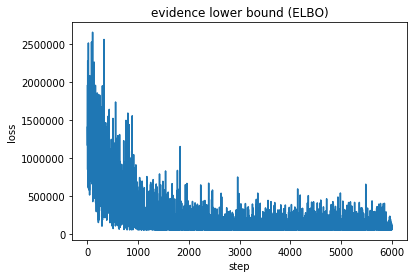

In [429]:
plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");
print('learned mean = ',pyro.param("mean"))

Text(0,0.5,'mean')

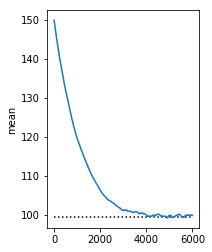

In [430]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[data.mean(),data.mean()], 'k:')
plt.plot(mean)
plt.ylabel('mean')

## Task

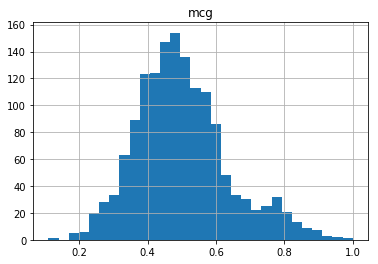

In [6]:
# Select one attriubte from one of the datasets (Task List 3), 
# that has distribution similar to Normal (or any known to you distribution)
yeast = pd.read_csv('yeast.csv', header=None)
yeast.columns = ["seq_name", "mcg", "gvh", "alm", "mit", "erl", "pox", "vac", "nuc", "class"]

# column to use - mcg
yeast.hist(column='mcg', bins=30)
data = torch.tensor(yeast.mcg)

In [7]:
data

tensor([0.5800, 0.4300, 0.6400,  ..., 0.6700, 0.4300, 0.6500])

In [22]:
pyro.enable_validation(True)
# Asume that you have some prior knowledge about parameters of that distribution
prior_mean = 0.4
print("prior mean: ", prior_mean)
print("real mean: ", data.mean())
print("real std: ", data.std())

prior mean:  0.4
real mean:  tensor(0.5001)
real std:  tensor(0.1373)


In [16]:
# Create model, and apropriate guide function
def model(data):  # approximate prior function
    with pyro.plate("map", len(data)):
        weight = pyro.sample("weight", pyro.distributions.Normal(prior_mean, 1.))
        return pyro.sample("measurement", pyro.distributions.Normal(weight, 1.), obs=data)

In [17]:
def guide(data):  # approximate posterior distribution
    # below line just saves "mean" in param store with value 1 and constraint that it is positive
    mean = pyro.param("mean", torch.tensor(1.), constraint=constraints.positive)
    # assume std = 0.14
    with pyro.plate("map", len(data)):
        return pyro.sample("weight", pyro.distributions.Normal(mean, 0.14))

In [23]:
# Learn parameter of your distribution, assume that you know STD or mean
# lr - learning rate
optim = Adam({"lr": 0.0003})
svi = pyro.infer.SVI(model=model,
                     guide=guide,
                     optim=optim,
                     loss=pyro.infer.Trace_ELBO(), num_samples=len(data))

# ELBO -> the difference between the distribution of a latent variable and the distribution of the respective observed variable

In [24]:
pyro.clear_param_store()
losses, mean  = [], []
num_steps = 10000
for t in tqdm(range(num_steps)):
    # takes one gradient step and returns estimate of loss
    losses.append(svi.step(data))
    mean.append(pyro.param("mean"))
    
print('learned mean = ', mean[-1])

100%|███████████████████████████████████| 10000/10000 [00:36<00:00, 275.77it/s]


learned mean =  tensor(0.4503, grad_fn=<AddBackward0>)


learned mean =  tensor(0.4503, grad_fn=<AddBackward0>)


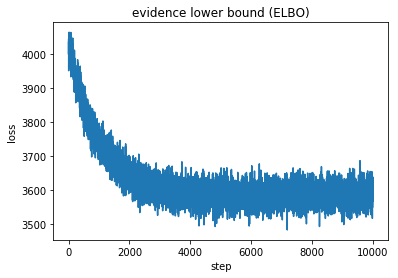

In [25]:
plt.plot(losses)
plt.title("evidence lower bound (ELBO)")
plt.xlabel("step")
plt.ylabel("loss");
print('learned mean = ',pyro.param("mean"))

Text(0, 0.5, 'mean')

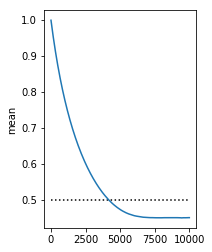

In [26]:
plt.subplot(1,2,1)
plt.plot([0,num_steps],[data.mean(),data.mean()], 'k:')
plt.plot(mean)
plt.ylabel('mean')